In [1]:
import sklearn.base
import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
import numpy as np
from collections import Counter
from sklearn.datasets import make_classification
from sklearn import neighbors
from sklearn.neighbors import kneighbors_graph
from imblearn.under_sampling import RandomUnderSampler

In [3]:
file = '/Users/cameronsellers/code/cecyprice/skin_lesion_detection/dataset/hmnist_8_8_RGB.csv'
test_images = pd.read_csv(file, ',')

In [4]:
file = '/Users/cameronsellers/code/cecyprice/skin_lesion_detection/dataset/HAM10000_metadata.csv'
data = pd.read_csv(file, ',')

In [5]:
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


# Workflow
---

- Take out duplicates and clean missing values
- Stratiifed undersample NV 
- Add back duplicates
- Augment 
- Encode 


### Clean missing values


In [5]:
data = pd.read_csv("../dataset/HAM10000_metadata.csv")
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [6]:
data.isnull().sum()
data['age'].fillna((data['age'].mean()), inplace = True)

## Take out Duplicates 

(array([5.514e+03, 0.000e+00, 1.423e+03, 0.000e+00, 4.900e+02, 0.000e+00,
        3.400e+01, 0.000e+00, 5.000e+00, 4.000e+00]),
 array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ]),
 <a list of 10 Patch objects>)

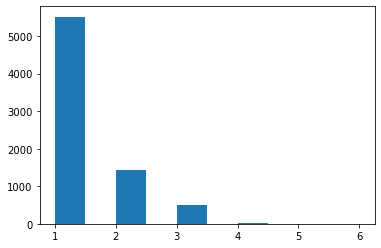

In [7]:
repetition_counts = data.groupby('lesion_id').agg({'image_id': 'count', 'dx_type': 'count', 'age': 'mean', 'sex': 'count', 'localization': 'count', 'dx': 'first', }).reset_index()
repetition_counts.columns = ['lesion_id', 'image_count', 'count_dx_type', 'mean_age', 'count_sex', 'count_location', 'dx']
plt.hist(repetition_counts.image_count)

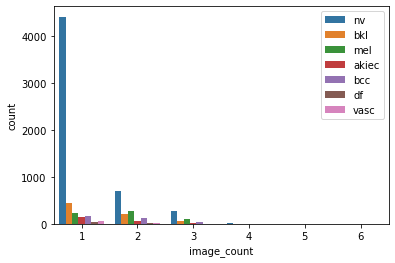

In [8]:
chart = repetition_counts[['image_count', 'dx', 'lesion_id']]
chart.head()
sns.countplot(x="image_count", hue="dx", data=chart)
plt.legend(loc='upper right')

In [9]:
def drop_duplicates(df): 
    df = df.drop_duplicates(subset=['lesion_id'], keep = 'first')
    return df

In [10]:
data = drop_duplicates(data)

In [11]:
data.shape

(7470, 7)

## Balancing Dataset 

nv       5403
bkl       727
mel       614
bcc       327
akiec     228
vasc       98
df         73
Name: dx, dtype: int64

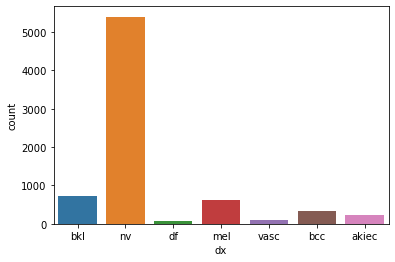

In [12]:
sns.countplot(data['dx'])
data['dx'].value_counts()

In [13]:
def balance(data, under_sample_size):
        
        ## isolate nv rows
        data_nv = data[data['dx'] == 'nv']
        
        # define scaling parameters 
        sample_size = under_sample_size
        scaling = under_sample_size / data_nv.shape[0] 
        
        # stratified sampling 
        rus = RandomUnderSampler(sampling_strategy={'lower extremity' : int(1224*scaling),
                                                    'trunk' : int(1153*scaling), 
                                                    'back' : int(1058*scaling),
                                                    'abdomen' : int(719*scaling), 
                                                    'upper extremity' : int(504*scaling) ,
                                                    'foot' : int(209*scaling), 
                                                    'unknown' : int(175*scaling),
                                                    'chest' : int(112*scaling),
                                                    'face' : int(61*scaling),
                                                    'neck' : int(60*scaling), 
                                                    'genital' : int(43*scaling), 
                                                    'hand' : int(39*scaling), 
                                                    'scalp' : int(24*scaling), 
                                                    'ear' : int(19*scaling),
                                                    'acral' : int(3*scaling)+1
                                                   }, 
                                   random_state=None,
                                   replacement=False,
                                )

        ## fit strtaified sampling model 
        n_x, n_y = rus.fit_resample(data_nv, data_nv['localization'])
        
        ## delete nv rows from original dataset
        no_nv_data = data[data.dx != 'nv']
        
        data = pd.concat([n_x, no_nv_data], axis=0)
        
        return data

# Data Augmentation

In [16]:
data = balance(data, 1000)
data2 = data.copy()
frame = [data, data2]
data = pd.concat(frame)

In [17]:
data.shape

(6122, 7)

In [20]:
age = data['age']
iqr = (age.quantile(q=0.75) - age.quantile(q=0.25))
iqr

25.0

In [33]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np
ohe = OneHotEncoder(sparse = False)
sex_oh = ohe.fit_transform(data[['sex']])
data['male'], data['female'], data['unknown'] = sex_oh.T
data

,lesion_id,image_id,dx,dx_type,age,sex,localization,male,female,unknown
0,HAM_0003977,ISIC_0026495,nv,follow_up,50.0,male,abdomen,0.0,1.0,0.0
1,HAM_0002014,ISIC_0031120,nv,follow_up,55.0,male,abdomen,0.0,1.0,0.0
2,HAM_0005944,ISIC_0030850,nv,follow_up,45.0,male,abdomen,0.0,1.0,0.0
3,HAM_0000014,ISIC_0025759,nv,histo,40.0,male,abdomen,0.0,1.0,0.0
4,HAM_0006901,ISIC_0026700,nv,follow_up,55.0,male,abdomen,0.0,1.0,0.0
5,HAM_0003403,ISIC_0031409,nv,follow_up,70.0,male,abdomen,0.0,1.0,0.0
6,HAM_0000927,ISIC_0027318,nv,follow_up,35.0,female,abdomen,1.0,0.0,0.0
7,HAM_0006773,ISIC_0026680,nv,follow_up,45.0,male,abdomen,0.0,1.0,0.0
8,HAM_0006948,ISIC_0026463,nv,follow_up,50.0,female,abdomen,1.0,0.0,0.0
9,HAM_0006530,ISIC_0029686,nv,follow_up,50.0,male,abdomen,0.0,1.0,0.0


In [40]:
data['localization'].unique()


array(['abdomen', 'acral', 'back', 'chest', 'ear', 'face', 'foot',
       'genital', 'hand', 'lower extremity', 'neck', 'scalp', 'trunk',
       'unknown', 'upper extremity'], dtype=object)

In [41]:
data.set_value(0, 'age', 2)
data.head()

c:\users\shrewsbury\.venvs\lewagon\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """Entry point for launching an IPython kernel.


,lesion_id,image_id,dx,dx_type,age,sex,localization,male,female,unknown
0,HAM_0003977,ISIC_0026495,nv,follow_up,2.0,male,abdomen,0.0,1.0,0.0
1,HAM_0002014,ISIC_0031120,nv,follow_up,55.0,male,abdomen,0.0,1.0,0.0
2,HAM_0005944,ISIC_0030850,nv,follow_up,45.0,male,abdomen,0.0,1.0,0.0
3,HAM_0000014,ISIC_0025759,nv,histo,40.0,male,abdomen,0.0,1.0,0.0
4,HAM_0006901,ISIC_0026700,nv,follow_up,55.0,male,abdomen,0.0,1.0,0.0


In [91]:
data = [['tom', 10, test_images[0]], ['charlie', 10, test_images[0]]]
  
# Create the pandas DataFrame 
dff = pd.DataFrame(data, columns = ['Name', 'Age', 'images_resized']) 
  
# print dataframe. 
dff 

,Name,Age,images_resized
0,tom,10,"[[[199, 156, 188], [210, 165, 198], [216, 176,..."
1,charlie,10,"[[[199, 156, 188], [210, 165, 198], [216, 176,..."


In [92]:
test_images[0].shape

(8, 8, 3)

In [137]:
def data_augmentation(df):

    ## Define random image modifications
    aug = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")
    
    ## Create np.array of augmented images from original images dataframe. Reshape to feed into dataGen
    images_array = np.array([i.reshape(75,100,3) for i in df['images_resized'].values])
    
    #construct the actual Python generator, iterate over imagegenerator object 
    dataGen = aug.flow(images_array, batch_size = len(df))
    for i in dataGen:
        break 
        
    ## flatten i before concatenating it into new dataframe copy 
    i = i.reshape(len(df), 22500)
    
    ## turn i from array into list so it can be converted into pd 
    im_list = []
    for im in i:
        im_list.append(im)
    
    # convert i into the pandas i_df 
    i_df = pd.DataFrame({'images_resized': im_list})
    print(i_df)
    
    # create new dataframe without image column and convert in np.array
    new_df = df.loc[:, df.columns != 'images_resized']
    
    ## concatenate new_df numpy array and new augmented image array 
    new_df = pd.concat((new_df, i_df), axis = 1)
    
    ## convert new_df back into pandas 
    new_df = pd.DataFrame(new_df)
    
    ## vertically concatenate new dataframes 
    frames = [df, new_df]
    df = pd.concat(frames)
    df.reset_index(drop=True, inplace=True)
    
    return df

In [136]:
data_augmentation(dff)

                                      images_resized
0  [207.54065, 158.83252, 188.24878, 207.60999, 1...
1  [197.93031, 153.06969, 160.93031, 197.03085, 1...
      Name  Age
0      tom   10
1  charlie   10


,Name,Age,images_resized
0,tom,10,"[[[199, 156, 188], [210, 165, 198], [216, 176,..."
1,charlie,10,"[[[199, 156, 188], [210, 165, 198], [216, 176,..."
2,tom,10,"[207.54065, 158.83252, 188.24878, 207.60999, 1..."
3,charlie,10,"[197.93031, 153.06969, 160.93031, 197.03085, 1..."


## Encoding features

In [23]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np

def sex_encoder():
    le = LabelEncoder()
    data['sex_encoded'] = le.fit_transform(data['sex'])
    return data

def ohe_feature_encoding(): 
    ohe = OneHotEncoder(sparse = False)
    feature_oh = ohe.fit_transform(data[['dx']])
    data['bkl'], data['nv'], data['df'], data['mel'], data['vasc'], data['bcc'], data['akiec'] = feature_oh.T
    return data 

def general_feature_encoding(v): 
    ohe = OneHotEncoder(sparse = False)
    feature_oh = ohe.fit_transform(data[[v]])
    list = data[v].unique().tolist()
    for l in list:
        count = 0
        while count <= len(list):
            data['l'] = feature_oh[:,(count-1)]
            count += 1
    return data 

In [24]:
data = ohe_feature_encoding()

In [25]:
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,bkl,nv,df,mel,vasc,bcc,akiec
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back,0.0,0.0,1.0,0.0,0.0,0.0,0.0


**Balance by sex insights**

Sex ratios (M/F) 
- NV (51:48) 
- BKL (61:38) 
- MEL (61:38) 


In [26]:
meta_data[meta_data['dx'] == 'nv']['sex'].value_counts(normalize = True)
## generally balanced by sex 

NameError: name 'meta_data' is not defined

In [ ]:
meta_data[meta_data['dx'] == 'bkl']['sex'].value_counts(normalize = True)

In [ ]:
meta_data[meta_data['dx'] == 'mel']['sex'].value_counts(normalize = True)

In [ ]:
meta_data[meta_data['dx'] == 'bcc']['sex'].value_counts(normalize = True)